In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pickle

import sys
sys.path.append("..")
from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs
from src.analysis.entropy import get_emoji_entropy
from src.data.utils import parallelize_dataframe

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

In [2]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

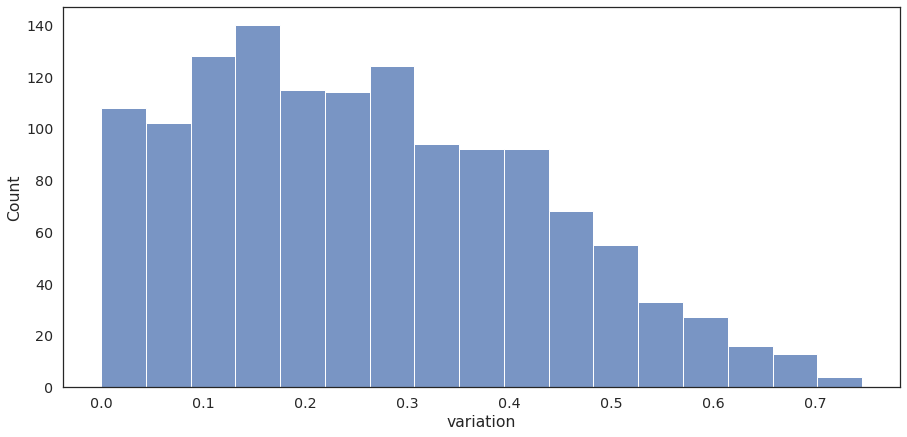

In [3]:
sns.histplot(data=variations.variation);

In [4]:
variations.describe()

,variation
count,1325.000000
mean,0.263352
std,0.164738
min,0.000000
25%,0.129710
50%,0.248651
75%,0.383876
max,0.745275


In [5]:
median_mask = variations.variation.sub(variations.variation.median()).abs().lt(0.001)
median_indices = median_mask[median_mask == True].index
print("Median emojis:")
print(variations.iloc[median_indices].emoji)

Median emojis:
454      🐊
590    👨‍🦽
625    👩‍🦲
763      📰
817      🔧
947      😹
Name: emoji, dtype: object


In [6]:
mean_mask = variations.variation.sub(variations.variation.mean()).abs().lt(0.001)
mean_indices = mean_mask[mean_mask == True].index
print("Mean emojis:")
print(variations.iloc[mean_indices].emoji)

Mean emojis:
83          ♾️
314          🍳
408         🏘️
586        👨‍🦱
596     👩‍❤️‍👩
892          😂
898          😈
1084         🤓
Name: emoji, dtype: object


## Check faces and gestures

In [7]:
faces_gestures = ["✊","✋","👆","👇","👈","👉","👊","👋","👌","👍","👎","👏","👐",
                 "😀", "😁", "😂", "😃", "😄","😅", "😆", "😇", "😈", "😉", "😊", "😋",
                 "😌","😍","😎","😏","😐","😑","😒","😓","😔","😕","😖","😗","😘","😙",
                 "😚","😛","😜","😝","😞","😟","😠","😡","😢","😣","😤","😥","😦","😧",
                 "😨","😩","😪","😫","😬","😭","😮","😯","😰","😱","😲","😳","😴","😵",
                 "😶","😷","😸","😹","😺","😻","😼","😽","😾","😿","🙀","🙁","🙂","🙃",
                 "🙄", "🙌", "🙏", "🤐","🤑","🤒","🤓","🤔","🤕","🤗","🤘","🤙","🤚",
                 "🤛","🤜","🤝","🤞","🤟","🤢","🤣","🤤","🤥","🤦","🤧","🤨","🤩","🤪",
                 "🤫","🤬","🤭","🤮","🤯","🤲","🥰","🥱","🥳","🥴","🥵","🥶","🥺","🧐",
                 "🤝‍","☹️","☺️","✊","✋","✌️", "🖐️","🖕","🖖", "🤐","🤑","🤒","🤓",
                 "🤔","🤕","🤗","🤘","🤙","🤚","🤛","🤜","🤝","🤞","🤟","🤠", '☹', '👿']

In [8]:
variations[variations.emoji.isin(faces_gestures)].sort_values("variation")[:10]

,emoji,vocabulary,variation,CIs
922,😠,"Counter({'angry': 23, 'mad': 1, 'unhappy': 1})",0.035486,"[0.0, 0.09324674129486084]"
949,😻,"Counter({'love': 25, 'inlove': 2, 'happy': 1, ...",0.080351,"[0.02447982341051102, 0.1508794392645359]"
129,✌️,"Counter({'peace': 25, 'TRUE': 1, 'relax': 1, '...",0.084923,"[0.02820313771565755, 0.15896132849156858]"
948,😺,"Counter({'cat': 24, 'happy': 2, 'chat': 1, 'ca...",0.095881,"[0.02230100076774071, 0.18138765803185003]"
1175,🥰,"Counter({'love': 19, 'happy': 2, 'loving': 1, ...",0.106312,"[0.04566994541221195, 0.17655334395390965]"
920,😞,"Counter({'sad': 23, 'tired': 3, 'frown': 1, 'd...",0.111193,"[0.037554232279459636, 0.19903217535465953]"
522,👌,"Counter({'ok': 12, 'okay': 12, 'super': 3, 'go...",0.127271,"[0.0659961565301336, 0.18798309777831207]"
525,👏,"Counter({'clap': 23, 'applause': 3, 'applaud':...",0.133750,"[0.04988404015700022, 0.22741053963700922]"
914,😘,"Counter({'kiss': 18, 'love': 4, 'kisses': 3, '...",0.145350,"[0.07644541099153716, 0.2251616644191331]"
517,👇,"Counter({'down': 20, 'finger': 2, 'pointer': 1...",0.146820,"[0.06350045907976372, 0.24162821724478686]"


In [9]:
variations[variations.emoji.isin(faces_gestures)].sort_values("variation", ascending=False)[:10]

,emoji,vocabulary,variation,CIs
1260,🧐,"Counter({'monocle': 6, 'searching': 2, 'curiou...",0.694345,"[0.5435997547381076, 0.7627329219293235]"
523,👍,"Counter({'thumbsup': 8, 'good': 6, 'like': 4, ...",0.655073,"[0.38782256208360194, 0.712130584390834]"
934,😬,"Counter({'yikes': 4, 'scared': 3, 'smile': 2, ...",0.606156,"[0.423053946060439, 0.7507692504425845]"
524,👎,"Counter({'no': 6, 'thumbsdown': 5, 'bad': 5, '...",0.603726,"[0.4143850159332423, 0.8223876923793536]"
912,😖,"Counter({'sour': 4, 'angry': 3, 'pain': 2, 'di...",0.599204,"[0.4077970568377238, 0.6612847234050816]"
863,🖖,"Counter({'vulcan': 8, 'hand': 4, 'peace': 4, '...",0.595715,"[0.44189021012521, 0.6746707146858862]"
906,😐,"Counter({'neutral': 8, 'meh': 4, 'sad': 3, 'fr...",0.570245,"[0.43055628772825005, 0.6584948569039503]"
1096,🤟,"Counter({'love': 4, 'hand': 2, 'rockon': 2, 'l...",0.556742,"[0.43575327717779394, 0.842666649424214]"
944,😶,"Counter({'silent': 4, 'speechless': 3, 'surpri...",0.540968,"[0.41339387579892684, 0.7092315663064186]"
1106,🤩,"Counter({'starstruck': 10, 'happy': 2, 'smile'...",0.528141,"[0.38398891305872085, 0.659946779354379]"


In [10]:
variations[variations.emoji.isin(faces_gestures)].describe()

,variation
count,130.000000
mean,0.322696
std,0.133341
min,0.035486
25%,0.226780
50%,0.319662
75%,0.401400
max,0.694345


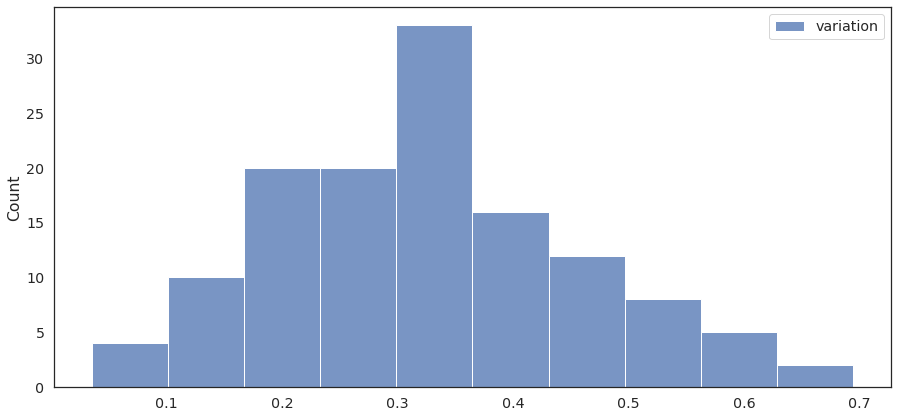

In [11]:
sns.histplot(data=variations[variations.emoji.isin(faces_gestures)], bins='doane');

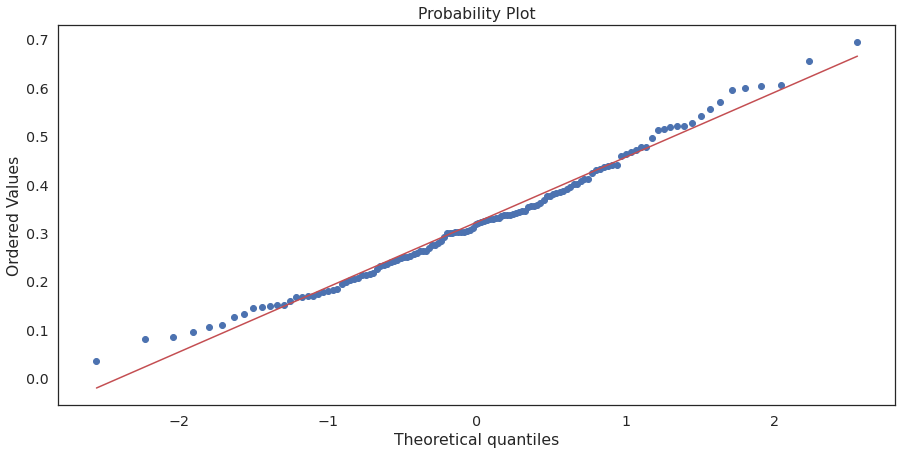

In [12]:
measurements = np.random.normal(loc=20, scale=5, size=100)   
stats.probplot(variations[variations.emoji.isin(faces_gestures)].variation, dist="norm", plot=plt);

## Check variation vs mean duration

In [13]:
emojis = pd.read_csv(AMBIGUITY_PATH)

In [14]:
variations = variations.set_index("emoji")
variations["mean_duration"] = emojis.groupby("emoji").Duration.sum() / emojis.groupby("emoji").WorkerID.count()

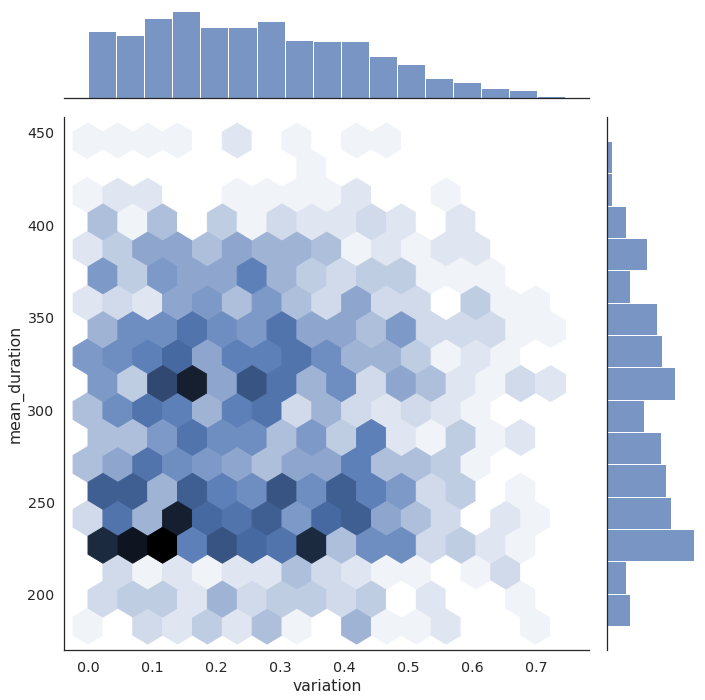

In [15]:
sns.jointplot(data=variations, x='variation', y='mean_duration', kind='hex', height=10);

### Variation vs entropy

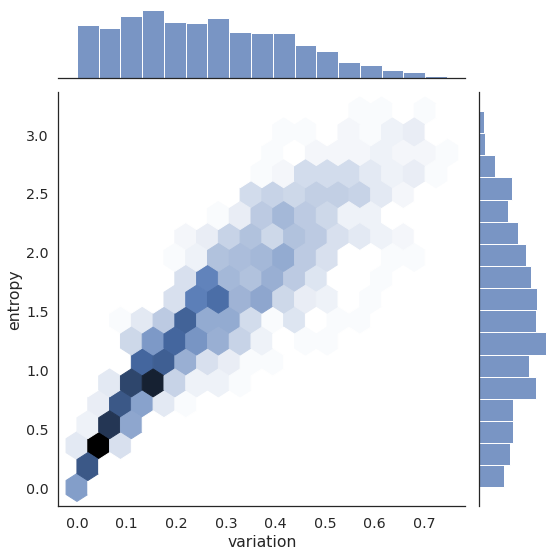

In [16]:
variations.vocabulary = [eval(el) for el in variations.vocabulary.tolist()]
variations["entropy"] = variations.vocabulary.apply(get_emoji_entropy)
sns.jointplot(data=variations, x='variation', y='entropy', kind='hex', height=8);

### Heatmap in embedded space

In [20]:
variations

,vocabulary,variation,CIs,mean_duration,entropy
emoji,,,,,
#️⃣,"{'pound': 0.3333333333333333, 'number': 0.3, '...",0.496355,"[0.34049082708855466, 0.5351314574386924]",375.600000,1.521423
*️⃣,"{'asterisk': 0.39285714285714285, 'star': 0.32...",0.584016,"[0.3850973823270968, 0.6565330826977255]",333.000000,1.584902
©️,"{'copyright': 0.6296296296296297, 'copywrite':...",0.276658,"[0.14734829440712927, 0.41018219388055577]",254.888889,1.389894
®️,"{'r': 0.25925925925925924, 'registered': 0.111...",0.576165,"[0.4251615431142488, 0.6953480601655662]",300.222222,2.495861
‼️,"{'exclamation': 0.3793103448275862, 'important...",0.494922,"[0.34701899029956806, 0.6155792427859429]",233.344828,2.068997
...,...,...,...,...,...
🪑,"{'chair': 0.8, 'sit': 0.1, 'char': 0.033333333...",0.094240,"[0.027714077631632486, 0.17764473814517254]",375.600000,0.748893
🪒,"{'razor': 0.5, 'shave': 0.23333333333333334, '...",0.297941,"[0.18200530243416627, 0.4025172619273264]",321.033333,1.437056
🪓,"{'axe': 0.5862068965517241, 'ax': 0.1034482758...",0.303265,"[0.17532045972244492, 0.43577796129574026]",338.344828,1.592797
